# Topic Modeling on our Hon.PM Shri Narendra Modi's Speech (Recorded Session Transcript)

![Topic Modeling PM US Speech](https://cdn.zeebiz.com/sites/default/files/2023/06/23/248256-india-us-joint-statement-2023-full-text-details-of-president-joe-biden-and-pm-narendra-modi.jpg)

After converting the speech-to-text recorded session of our Hon.PM Shri Narendra Modi during his America Visit in 2014, now it is time to preprocess the text and implement various topic modeling algorithms, namely, **Latent Dirichlet Allocation (LDA)**, **Latent Semantic Analysis (LSA)**, and **BERTopic**.

So, without further ado, Let’s begin.


### Downloading required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 20.1 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
pip install lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.4 MB/s eta 0:00:00


In [ ]:
pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 740.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.3 MB/s eta 0:00:00


### Importing the Relevant Libraries

In [ ]:
# Importing general libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pdfplumber

# Importing the Gensim library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# I will use this library for implementing the truncated singular value decomposition for the LSA model
from gensim.models import LsiModel


# Importing nltk and downloading stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Importing spacy for lemmatization
import spacy

# Importing the BERTopic model
from bertopic import BERTopic
# Importing the sentence-transformers package for the purpose of document embeddings
from sentence_transformers import SentenceTransformer
from sentence_transformers import *
# Importing UMAP for dimensionality reduction in the BERTopic model
import umap
# Importing HDBSCAN to perform its clustering
import hdbscan

# Importing various dimensionality reduction and clustering techniques
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Importing LexRank, an unsupervised approach to text summarization based on graph-based centrality scoring of sentences
from lexrank import *
# Importing the torch package
import torch


# Importing plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Enabling logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Importing warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Preparing Stopwords

In [ ]:
# Importing NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Importing our Corpus Document

In [ ]:
# Open the PDF file
with pdfplumber.open('/content/drive/MyDrive/Topic Modeling/USA2014.pdf') as pdf:
    # Extract text from all pages
    text = ''
    for page in pdf.pages:
        text += page.extract_text()

# Tokenize the text into sentences
sentences = nltk.sent_tokenize(text)

# Create a DataFrame from the sentences
df = pd.DataFrame(sentences, columns=['sentence'])

# Display the first 10 sentences of the DataFrame
print(df.head(10))


                                            sentence
0                                 Hail Mother India!
1           My dear brothers and sisters in America!
2  All the respectable dignitaries of American po...
3  My greetings as well to the people who could n...
4             Wishing you all a Very Happy Navratri!
5  The festival of Navratri is meant to worship p...
6                  It is a festival of purification.
7   It is an occasion to\nstrengthen our dedication.
8  I have the good fortune of meeting you on such...
9  I am\nproud that my fellow countrymen who desp...


In [ ]:
from wordcloud import WordCloud
wordcloud1 = WordCloud().generate(' '.join(sentences))


(-0.5, 399.5, 199.5, -0.5)

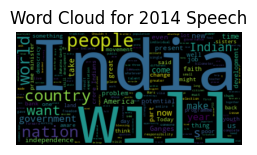

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud for 2014 Speech')
plt.axis('off')

In [ ]:
df['sentence'].shape

(352,)

There are only 352 sentences in my corpus from the recoded session of our Hon.PM Narendra Modi's Speech. This is a very small dataset, but to test our hypostasis of how well different types of topic models cope with this type of small dataset we will have to implement this corpus and reach the relevant conclusions based on the results.

So, let's continue

### Removing Emails and Newline Characters

In [ ]:
# Converting to list
data = df.sentence.values.tolist()

# Removing new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]



# Removing distracting single marks
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub(",", "", sent) for sent in data]
data = [re.sub("\[", "", sent) for sent in data]
data = [re.sub("\]", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]


print(data)

['Hail Mother India!', 'My dear brothers and sisters in America!', 'All the respectable dignitaries of American politics especially present here for this ceremony and my fellow Indians watching this programme today on television and the internet.', 'My greetings as well to the people who could not make it to this auditorium and are standing outside.', 'Wishing you all a Very Happy Navratri!', 'The festival of Navratri is meant to worship power.', 'It is a festival of purification.', 'It is an occasion to strengthen our dedication.', 'I have the good fortune of meeting you on such a pious occasion.', 'I am proud that my fellow countrymen who despite being far away from their land have created a name for India and have enhanced its glory and honour.', 'Otherwise there was a time when our country was known as the land of snake charmers.', 'Had it not been for you had it not been the youth of our country if you would not have achieved these feats in the field of information technology then

### Tokenizing Words and Clean-Up Text

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

[['hail', 'mother', 'india'], ['my', 'dear', 'brothers', 'and', 'sisters', 'in', 'america'], ['all', 'the', 'respectable', 'dignitaries', 'of', 'american', 'politics', 'especially', 'present', 'here', 'for', 'this', 'ceremony', 'and', 'my', 'fellow', 'indians', 'watching', 'this', 'programme', 'today', 'on', 'television', 'and', 'the', 'internet'], ['my', 'greetings', 'as', 'well', 'to', 'the', 'people', 'who', 'could', 'not', 'make', 'it', 'to', 'this', 'auditorium', 'and', 'are', 'standing', 'outside'], ['wishing', 'you', 'all', 'very', 'happy', 'navratri'], ['the', 'festival', 'of', 'navratri', 'is', 'meant', 'to', 'worship', 'power'], ['it', 'is', 'festival', 'of', 'purification'], ['it', 'is', 'an', 'occasion', 'to', 'strengthen', 'our', 'dedication'], ['have', 'the', 'good', 'fortune', 'of', 'meeting', 'you', 'on', 'such', 'pious', 'occasion'], ['am', 'proud', 'that', 'my', 'fellow', 'countrymen', 'who', 'despite', 'being', 'far', 'away', 'from', 'their', 'land', 'have', 'created

### Creating Bigram and Trigram Models

In [ ]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
data_words = [trigram_mod[bigram_mod[word]] for word in data_words]
print(data_words)


[['hail', 'mother', 'india'], ['my', 'dear', 'brothers', 'and', 'sisters', 'in', 'america'], ['all', 'the', 'respectable', 'dignitaries', 'of', 'american', 'politics', 'especially', 'present', 'here', 'for', 'this', 'ceremony', 'and', 'my', 'fellow', 'indians', 'watching', 'this', 'programme', 'today', 'on', 'television', 'and', 'the', 'internet'], ['my', 'greetings', 'as', 'well', 'to', 'the', 'people', 'who', 'could', 'not', 'make', 'it', 'to', 'this', 'auditorium', 'and', 'are', 'standing', 'outside'], ['wishing', 'you', 'all', 'very', 'happy', 'navratri'], ['the', 'festival', 'of', 'navratri', 'is', 'meant', 'to', 'worship', 'power'], ['it', 'is', 'festival', 'of', 'purification'], ['it', 'is', 'an', 'occasion', 'to', 'strengthen', 'our', 'dedication'], ['have', 'the', 'good', 'fortune', 'of', 'meeting', 'you', 'on', 'such', 'pious', 'occasion'], ['am', 'proud', 'that', 'my', 'fellow', 'countrymen', 'who', 'despite', 'being', 'far', 'away', 'from', 'their', 'land', 'have', 'created

### Removing Stopwords and Making Bigrams and Lemmatization

In [ ]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Preforming lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

[[], ['dear', 'brother', 'sister'], ['respectable', 'dignitary', 'american', 'politic', 'especially', 'present', 'ceremony', 'fellow', 'watch', 'programme', 'today', 'television', 'internet'], ['greeting', 'well', 'people', 'make', 'auditorium', 'stand', 'outside'], ['wish', 'happy', 'navratri'], ['festival', 'navratri', 'mean', 'worship', 'power'], ['festival', 'purification'], ['occasion', 'strengthen', 'dedication'], ['good', 'fortune', 'meeting', 'pious', 'occasion'], ['proud', 'fellow', 'countryman', 'far', 'away', 'land', 'create', 'name', 'enhance', 'glory', 'honour'], ['otherwise', 'time', 'country', 'know', 'land', 'snake', 'charmer'], ['youth', 'country', 'achieve', 'field', 'information', 'technology', 'still', 'reputation', 'land', 'snake', 'charmer'], ['year'], ['time', 'chief', 'minister'], ['accompany'], ['acquaintance', 'spend', 'day', 'together'], ['day', 'ask', 'mind', 'like', 'ask', 'question'], ['say', 'go', 'ahead', 'mind'], ['still', 'apprehensive', 'hesitant'], [

In [ ]:
len(data_lemmatized)

352

### Creating the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing the Term Document Frequency
print(corpus)

[[], [(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1), (25, 1)], [(24, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(26, 1), (30, 1)], [(31, 1), (32, 1), (33, 1)], [(32, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(7, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(45, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(45, 1), (48, 1), (49, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)], [(61, 1)], [(53, 1), (62, 1), (63, 1)], [(64, 1)], [(65, 1), (66, 1), (67, 1), (68, 1)], [(66, 1), (69, 2), (70, 1), (71, 1), (72, 1)], [(71, 1), (73, 1), (74, 1), (75, 1)], [(58, 1), (76, 1), (77, 1)], [(20, 1), (75, 1), (78, 1), (79, 1), (80, 1), (81, 1)], [(48, 1), (49, 1), (52, 2)], [(15, 1), (20, 1), (58, 1)], [], [(75, 1)], [(49, 1), (82, 1), (83

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[],
 [('brother', 1), ('dear', 1), ('sister', 1)],
 [('american', 1),
  ('ceremony', 1),
  ('dignitary', 1),
  ('especially', 1),
  ('fellow', 1),
  ('internet', 1),
  ('politic', 1),
  ('present', 1),
  ('programme', 1),
  ('respectable', 1),
  ('television', 1),
  ('today', 1),
  ('watch', 1)],
 [('auditorium', 1),
  ('greeting', 1),
  ('make', 1),
  ('outside', 1),
  ('people', 1),
  ('stand', 1),
  ('well', 1)],
 [('happy', 1), ('navratri', 1), ('wish', 1)],
 [('navratri', 1), ('festival', 1), ('mean', 1), ('power', 1), ('worship', 1)],
 [('festival', 1), ('purification', 1)],
 [('dedication', 1), ('occasion', 1), ('strengthen', 1)],
 [('occasion', 1), ('fortune', 1), ('good', 1), ('meeting', 1), ('pious', 1)],
 [('fellow', 1),
  ('away', 1),
  ('countryman', 1),
  ('create', 1),
  ('enhance', 1),
  ('far', 1),
  ('glory', 1),
  ('honour', 1),
  ('land', 1),
  ('name', 1),
  ('proud', 1)],
 [('land', 1),
  ('charmer', 1),
  ('country', 1),
  ('know', 1),
  ('otherwise', 1),
  ('sn

### Building the LDA Topic Model

**Latent Dirichlet Allocation (LDA)** is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics.
LDA is one of the most popular topic modeling methods.

In [ ]:
# Building the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1, # Determines how often the model parameters should be updated
                                           chunksize=10, # The number of documents to be used in each training chunk
                                           passes=10, # Total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

### Viewing the Topics in The LDA Model

In [ ]:
# Printing the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"problem" + 0.029*"take" + 0.025*"time" + 0.022*"land" + 0.020*"bear" '
  '+ 0.019*"motherland" + 0.016*"create" + 0.012*"migrant" + 0.012*"school" + '
  '0.011*"cleanliness"'),
 (1,
  '0.042*"people" + 0.037*"want" + 0.036*"indian" + 0.028*"give" + '
  '0.026*"thing" + 0.025*"make" + 0.019*"get" + 0.017*"love" + 0.016*"think" + '
  '0.015*"job"'),
 (2,
  '0.076*"thank" + 0.066*"much" + 0.055*"come" + 0.026*"go" + 0.018*"heart" + '
  '0.016*"single" + 0.016*"start" + 0.015*"study" + 0.013*"believe" + '
  '0.011*"even"'),
 (3,
  '0.051*"year" + 0.039*"country" + 0.027*"tell" + 0.022*"choose" + '
  '0.019*"service" + 0.018*"news" + 0.018*"man" + 0.017*"let" + 0.016*"great" '
  '+ 0.014*"expectation"'),
 (4,
  '0.028*"visit" + 0.026*"issue" + 0.024*"small" + 0.023*"visa" + '
  '0.021*"clean" + 0.020*"dream" + 0.020*"repay" + 0.017*"gange" + '
  '0.017*"long" + 0.016*"look"')]


### Computing Model Perplexity and Coherence Score

In [ ]:
# Computing Perplexity
print('\nPerplexity Score: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity Score:  -7.803490569851006

Coherence Score:  0.6052783727470896


### Visualizing the Topics-Keywords

In [ ]:
# Visualizing the topics using pyLDAvis package's interactive chart
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.150545  0.146711       1        1  25.057290
3     -0.012752 -0.090420       2        1  22.545328
2      0.204296  0.087917       3        1  18.010168
0     -0.026053 -0.073578       4        1  17.533329
4     -0.014945 -0.070631       5        1  16.853887, topic_info=         Term       Freq      Total Category  logprob  loglift
131     thank  24.000000  24.000000  Default  30.0000  30.0000
123      much  21.000000  21.000000  Default  29.0000  29.0000
126      come  17.000000  17.000000  Default  28.0000  28.0000
61       year  20.000000  20.000000  Default  27.0000  27.0000
20     people  18.000000  18.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
671      visa   6.565898  13.643222   Topic5  -3.7812   1.0492
602     gange   4.950542  10.012118   Topic5  -4.0636   1.0763
669      card   2.190945   5.288824   Topic5  -4.8787   0.8993
670    holder   2.190945   5.288824   Topic5  -4.8787   0.8993
692  national   1.883282   3.404402   Topic5  -5.0301   1.1885

[204 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
445       5  0.792356   accomplish
659       4  0.758714    ahmedabad
3         4  0.603296     american
628       3  0.637478  anniversary
69        2  0.935432          ask
...     ...       ...          ...
508       5  0.919294        visit
186       1  0.962419         want
15        3  0.868930        watch
91        5  0.736305        world
61        2  0.982006         year

[201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])

# Latent Semantic Analysis (LSA) Topic Modeling
Latent Semantic Analysis (LSA) also known as Latent Semantic Index (LSI) is a natural language processing method that analyzes relationships between a set of documents and the terms contained within. It uses singular value decomposition, a mathematical technique, to scan unstructured data to find hidden relationships between terms and concepts.





  







Again, We can obtain the coherence score with the Gensim module. Let’s see how the coherence score is for the LSA model for a total of 5 topics (The same number of topics as We initially chose for the LDA model. For comparison purposes).  
**Note** - LsiModel does not function with the log_preplexity for the calculation of the perplexity score the same as LDA does. So, I will drop the perplexity score and focus my attention only to the coherence score.

In [ ]:
lsi = LsiModel(corpus, num_topics=5, id2word=id2word, chunksize=10)

# Computing Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.4077889778595365


We get a better Coherence Score this time by using LsiModel

### Performing SVD

In [ ]:
# performing SVD on the bag of words with the LsiModel to extract 5 topics
lsi = LsiModel(corpus, num_topics=5, id2word=id2word)

In [ ]:
# finding the 10 words with the srongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.539*"people" + 0.402*"nation" + 0.335*"country" + 0.287*"world" + 0.230*"want" + 0.128*"come" + 0.118*"make" + 0.107*"youth" + 0.106*"old" + 0.106*"development".
Words in 1: 0.650*"nation" + -0.443*"people" + -0.206*"country" + 0.203*"world" + 0.190*"youth" + 0.138*"year" + -0.132*"want" + -0.118*"make" + 0.106*"population" + 0.106*"create".
Words in 2: 0.627*"country" + 0.300*"world" + -0.254*"development" + -0.206*"people" + -0.203*"movement" + -0.174*"make" + -0.158*"government" + -0.132*"nation" + -0.131*"become" + -0.129*"freedom".
Words in 3: -0.684*"world" + 0.331*"country" + 0.254*"nation" + -0.250*"come" + -0.131*"settle" + -0.118*"part" + 0.110*"make" + 0.105*"want" + -0.088*"believe" + -0.087*"faith".
Words in 4: 0.454*"make" + -0.321*"come" + -0.311*"people" + 0.293*"want" + 0.272*"world" + 0.223*"development" + 0.164*"movement" + -0.125*"say" + 0.119*"brother" + 0.119*"sister".


##

# BERTopic

**BERTopic** is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.






After preprocessing the dataset early in my project and reaching to a final lemmatized dataset (named: **data_lemmatized**) containing the final product words that We have been working with. Now, We want to add those words to my dataframe as a set of rows and their corresponding words. After doing that, We would like to convert does words back to sentences for the purpose of using the sentence transformer model from BERTopic.

In [ ]:
# Adding new column to the dataframe (named: text_cleaned)
# containing the different lemmatized words in each corresponding row.
df['text_cleaned'] = data_lemmatized

In [ ]:
# Function to make it back into a sentence
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [ ]:
# Converting all the texts back to sentences
make_sentences(df, 'text_cleaned')

In [ ]:
df.head()

,sentence,text_cleaned
0,Hail Mother India!,
1,My dear brothers and sisters in America!,dear brother sister
2,All the respectable dignitaries of American po...,respectable dignitary american politic especia...
3,My greetings as well to the people who could n...,greeting well people make auditorium stand out...
4,Wishing you all a Very Happy Navratri!,wish happy navratri


### Importing a Pre-Trained Model from SentenceTransformer

In [ ]:
# Getting a model
model=SentenceTransformer('all-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Encodinng The Preprocessed Text Data

In [ ]:
embeddings = model.encode(df['text_cleaned'])

### Getting Topics Using BERTopic and SentenceTransformer Embeddings

In [ ]:
model2 = BERTopic()
topics, probabilities = model2.fit_transform(df['text_cleaned'],embeddings)

In [ ]:
# viewing how frequent certain topics are
model2.get_topic_freq().head()

,Topic,Count
1,0,330
0,1,22


The topic name -1 refers to all documents that did not have any topics assigned.
Not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

After generating topics and their probabilities, I can access the frequent topics that were generated.

In [ ]:
model2.get_topic(0)

[('people', 0.07182939556183957),
 ('world', 0.058273442204651235),
 ('nation', 0.05386321153277649),
 ('country', 0.050817780187583594),
 ('want', 0.04443938943648876),
 ('make', 0.04443938943648876),
 ('come', 0.03936428632796287),
 ('take', 0.03760851284149504),
 ('government', 0.03581729050732219),
 ('year', 0.03581729050732219)]

In [ ]:
model2.get_topic(1)

[('news', 1.1436291132333678),
 ('pain', 0.7501223854374177),
 ('rich', 0.7501223854374177),
 ('definitely', 0.7501223854374177),
 ('commonality', 0.7501223854374177),
 ('return', 0.6732359106201996),
 ('hope', 0.6732359106201996),
 ('different', 0.5964788598186745),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
model2.get_topic(2)

False

In [ ]:
model2.get_topics()

{0: [('people', 0.07182939556183957),
  ('world', 0.058273442204651235),
  ('nation', 0.05386321153277649),
  ('country', 0.050817780187583594),
  ('want', 0.04443938943648876),
  ('make', 0.04443938943648876),
  ('come', 0.03936428632796287),
  ('take', 0.03760851284149504),
  ('government', 0.03581729050732219),
  ('year', 0.03581729050732219)],
 1: [('news', 1.1436291132333678),
  ('pain', 0.7501223854374177),
  ('rich', 0.7501223854374177),
  ('definitely', 0.7501223854374177),
  ('commonality', 0.7501223854374177),
  ('return', 0.6732359106201996),
  ('hope', 0.6732359106201996),
  ('different', 0.5964788598186745),
  ('', 1e-05),
  ('', 1e-05)]}

I can view all the topics discussed in all of the documents.

There is some favorable advantage for the LDA model over the other two models with regards to the interpretation and insights regarding the theme discussed in the recorded session. Explaining the results and reaching the relevant conclusions will take part in the paper that will be submitted along side this code implementation.



 ### THANK YOU

      
        
          
          





















![Thank You NLP](https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy)


